In [115]:
import torch
import torch.nn as nn
from torch.utils.data import DataLoader, TensorDataset
from torchvision import datasets, transforms
from tqdm import tqdm, trange
import matplotlib.pyplot as plt
import json

import random
from utils import accuracy

In [116]:
num_epochs = 50
lr = 1e-2
device = torch.device("cuda:0")
# Transformation
transform_train = transforms.Compose([
    transforms.RandomAffine(
        degrees=15,                   # Rotation within ±15 degrees
        translate=(0.2, 0.2),         # Random translation up to 20% of the image size
        scale=(0.5, 1.2)              # Random scaling between 0.5x to 1.2x
    ),
    # transforms.RandomHorizontalFlip(p=0.5),  # Random horizontal flip with 50% probability
    transforms.ToTensor(),                    # Convert PIL image to tensor
    transforms.Lambda(lambda img: 1 - img if random.random() < 0.5 else img)  # Invert colors with 50% probability
])
transform_val = transforms.Compose([
    transforms.ToTensor(),  # Convert PIL image to tensor
])

# Load MNIST dataset into memory
train_dataset = datasets.MNIST(root='./data', train=True, download=True, transform=transform_train)
test_dataset = datasets.MNIST(root='./data', train=False, download=True, transform=transform_val)

# Create DataLoaders
train_loader = DataLoader(train_dataset, batch_size=1024, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=1024, shuffle=False)

In [117]:
class MLP(nn.Module):
    def __init__(self):
        super().__init__()
        self.flatten = nn.Flatten()
        self.fc1 = nn.Linear(28*28, 300)  # input layer (28x28 images)
        self.fc2 = nn.Linear(300, 100)   # hidden layer
        self.fc3 = nn.Linear(100, 10)    # output layer

    def forward(self, x):
        x = self.flatten(x)
        # print(x.shape)
        x = torch.relu(self.fc1(x))     # activation function for hidden layer
        x = torch.relu(self.fc2(x))
        x = self.fc3(x)
        return x

class ConvNet(nn.Module):
    def __init__(self):
        super().__init__()
        self.conv1 = nn.Conv2d(1, 4, kernel_size=3, stride=1, padding=1)
        self.relu1 = nn.ReLU()
        self.pool1 = nn.MaxPool2d(kernel_size=2, stride=2)

        self.conv2 = nn.Conv2d(4, 16, kernel_size=3, stride=1, padding=1)
        self.relu2 = nn.ReLU()
        self.pool2 = nn.MaxPool2d(kernel_size=2, stride=2)

        self.flatten = nn.Flatten()
        self.fc1 = nn.Linear(7*7*16, 100)
        self.relu3 = nn.ReLU()
        self.fc2 = nn.Linear(100, 10)

    def forward(self, x):
        x = self.conv1(x)
        x = self.relu1(x)
        x = self.pool1(x)  # 28x28 -> 14x14

        x = self.conv2(x)
        x = self.relu2(x)
        x = self.pool2(x)  # 14x14 -> 7x7
        
        x = self.flatten(x)
        x = self.fc1(x)
        x = self.relu3(x)
        x = self.fc2(x)
        return x

# model = MLP()
model = ConvNet()

model.to(device)

ConvNet(
  (conv1): Conv2d(1, 4, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (relu1): ReLU()
  (pool1): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (conv2): Conv2d(4, 16, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (relu2): ReLU()
  (pool2): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (flatten): Flatten(start_dim=1, end_dim=-1)
  (fc1): Linear(in_features=784, out_features=100, bias=True)
  (relu3): ReLU()
  (fc2): Linear(in_features=100, out_features=10, bias=True)
)

In [118]:
# Initialize empty lists to store train and test accuracies and losses
train_accuracies = []
test_accuracies = []
train_losses = []

In [119]:
optimizer = torch.optim.Adam(model.parameters(), lr=lr, weight_decay=1e-5)
criterion = nn.CrossEntropyLoss()

In [120]:
for epoch in trange(num_epochs, desc=f"Training (lr={lr})"):
    model.train()
    for data, target in train_loader:
        data, target = data.to(device), target.to(device)
        optimizer.zero_grad()
        # print(data.shape)
        output = model(data)
        loss = criterion(output, target)
        loss.backward()
        optimizer.step()

    train_losses.append(loss.item())
    train_accuracies.append(accuracy(model, train_loader, device))
    test_accuracies.append(accuracy(model, test_loader, device))
    # print(f"Loss: {loss.item()}, Train accuracy: {train_accuracies[-1]}, Test accuracy: {test_accuracies[-1]}")

    if epoch == num_epochs - 20:
        # print("Decreasing learning rate")
        for param_group in optimizer.param_groups:
            param_group['lr'] /= 10
            lr /= 10

Training (lr=0.01): 100%|██████████| 50/50 [06:08<00:00,  7.37s/it]


In [121]:
with open('runs3.json', 'w') as f:
    data = {
        'train_accuracies': train_accuracies,
        'test_accuracies': test_accuracies,
        'train_losses': train_losses
    }
    json.dump(data, f)

In [122]:
with open('runs3.json', 'r') as f:
    data = json.load(f)

train_accuracies = data['train_accuracies']
test_accuracies = data['test_accuracies']
train_losses = data['train_losses']

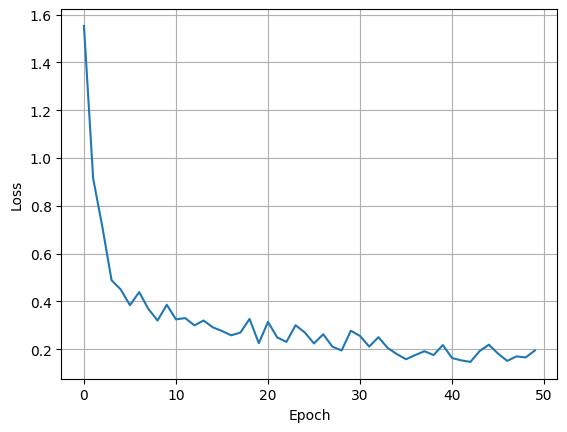

In [123]:
plt.plot(train_losses, label='train loss')

plt.xlabel('Epoch')
plt.ylabel('Loss')

plt.grid()

plt.savefig('mlp_loss.pdf')

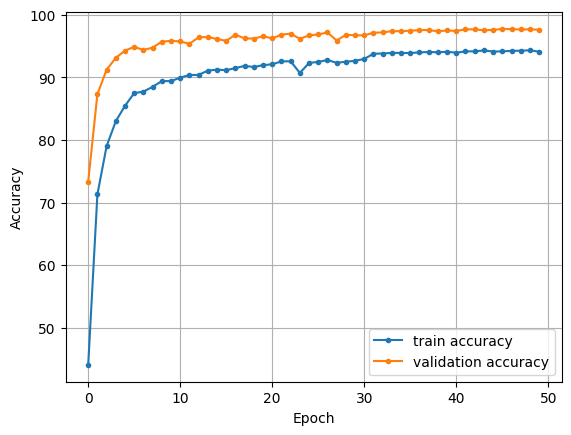

In [124]:
plt.plot(train_accuracies, ".-", label='train accuracy')
plt.plot(test_accuracies, ".-", label='validation accuracy')

plt.xlabel('Epoch')
plt.ylabel('Accuracy')

plt.grid()
plt.legend()
plt.savefig('mlp_acc.pdf', bbox_inches='tight')

In [125]:
# save the model, optimizer, loss function, train_accuracies, test_accuracies, train_losses
torch.save({
    'model': model,
    # 'optimizer': optimizer.state_dict(),
    # 'criterion': criterion,
    # 'train_accuracies': train_accuracies,
    # 'test_accuracies': test_accuracies,
    # 'train_losses': train_losses
}, 'model_aug.pth')